In [0]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
import collections
from collections import Counter
import warnings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\boyas\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [0]:
review = pd.read_json('reviews_Health_and_Personal_Care_5.json.gz', lines = True)
review.head()

In [0]:
review_copy = review.copy()
review_copy["binary"] = review_copy["overall"].apply(lambda x: 1 if x>=4 else 0)
N = len(review_copy)

In [0]:
def balance_dataset_undersampling(df):
     # Equalize positive and negative instances
    equalized_dataset_neg = df[(df['binary'] == 0)]
    equalized_dataset_pos = df[(df['binary'] == 1)].sample(n=equalized_dataset_neg.shape[0], random_state = 1)
    equalized_dataset = pd.concat([equalized_dataset_pos, equalized_dataset_neg])
    equalized_dataset = equalized_dataset.sample(n=int(0.2*N), random_state = 1)
    return equalized_dataset

In [0]:
bal_review_copy = balance_dataset_undersampling(review_copy)
# del review_copy
# print(sum(bal_review_copy["binary"] == 1))
# print(sum(bal_review_copy["binary"] == 0))
# bal_review_copy.to_csv("bal_review_copy.csv")

In [0]:
bal_review_copy = pd.read_csv("bal_review_copy.csv", index_col = 0)
bal_review_copy.sort_values("reviewerID").head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,binary
194225,A0010876CNE3ILIM9HV0,B003983HRI,JassyR,"[0, 0]",I recently received this razor for free from G...,5,A five star razor,1369699200,"05 28, 2013",1
301745,A00328401T70RFN4P1IT6,B00A406OWY,Susan,"[0, 0]",What works about this product is that combinat...,5,Great Combination of Things,1360886400,"02 15, 2013",1
308103,A00428403I6YA6YYRHJD8,B00B2N4YP6,MKS,"[0, 0]",I've noticed a difference in my appetite cycle...,5,Works best with regular excercise regiment,1405123200,"07 12, 2014",1
324841,A00473363TJ8YSZ3YAGG9,B00DY01GOM,Thomas Rogers,"[0, 0]",The wipes themselves are tough enough to do th...,3,Cottonelle Fresh Care Flushable Moist Wipes Up...,1400716800,"05 22, 2014",0
24734,A00473363TJ8YSZ3YAGG9,B0002YUY5A,Thomas Rogers,"[0, 1]",It's ok in the sense i hope the antibacterial ...,3,Mr. Clean Antibacterial Summer Citrus Multi-Su...,1400716800,"05 22, 2014",0


# BOW

In [0]:
review_bow = bal_review_copy.copy()
review_bow.shape

(69271, 10)

In [0]:
def lowercase_remove_stopwords(text):
    '''
    Remove stop words
    '''
    text = str(text)
    text = text.replace('can\'t', 'can not')
    text = text.replace('n\'t', ' not')
    text_without_stopwords = [word for word in re.split(r'\W+', text.lower()) if word not in stopwords_without_neg]
    return ' '.join(text_without_stopwords).strip()

In [0]:
stop_words = stopwords.words('english')
stopwords_without_neg = [word for word in stop_words if ('n\'t' not in word) and ('not' not in word)]
review_bow['reviewText'] = review_bow['reviewText'].progress_apply(lowercase_remove_stopwords)

In [0]:
def handle_negation(text):
    '''
    Convert xxxn't to 'xxx' and 'not'
    '''
    r = re.compile(r'(not) ([\S]+)')
    if r.findall(text) != []:
        text = r.sub(r'\1_\2', text)
    return text

In [0]:
review_bow['reviewText'] = review_bow['reviewText'].progress_apply(handle_negation)

In [0]:
stemmer = PorterStemmer()
def stemming(text):
    '''
    Stem all words by Porter
    '''
    plurals = text.split()
    singles = [stemmer.stem(plural) for plural in plurals]
    return ' '.join(singles)

In [0]:
review_bow['reviewText'] = review_bow['reviewText'].progress_apply(stemming)

In [0]:
def top500(wordfreq):
    '''
    Find the most frequent 500 words
    '''
    aux = [(wordfreq[key], key) for key in wordfreq]
    aux.sort(reverse = True)
    words = [word for count, word in aux[:500]]
    return words

In [0]:
review_words = ' '.join(review_bow.reviewText.values.tolist())
word_df = pd.DataFrame(review_words.split(), columns = ['Words'])
wordfreq = dict(word_df['Words'].value_counts())
freq_words = top500(wordfreq)

In [0]:
def BoW(text):
    '''
    Create Bag of Words for each review
    '''
    vector = [] 
    for word in freq_words: 
        if word in text.split(): 
            vector.append(1) 
        else: 
            vector.append(0) 
    return vector

In [0]:
review_bow['BoW'] = review_bow['reviewText'].progress_apply(BoW)
bow_for_all = pd.DataFrame(np.asarray([bow for bow in review_bow['BoW']]), columns = freq_words)

In [0]:
X = bow_for_all
y = review_bow['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Models

### 1. Logistic Regression

In [0]:
logreg = LogisticRegression()
parameters = {'C': [0.5, 1], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 
              'max_iter': [100, 150, 200]}
clf = GridSearchCV(logreg, parameters)
clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1], 'max_iter': [100, 150, 200],
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
clf.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
logreg = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(X_train_res, y_train_res)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [0]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[19999  6769]
 [28340 83434]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.75      0.53     26768
           1       0.92      0.75      0.83    111774

    accuracy                           0.75    138542
   macro avg       0.67      0.75      0.68    138542
weighted avg       0.83      0.75      0.77    138542



In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

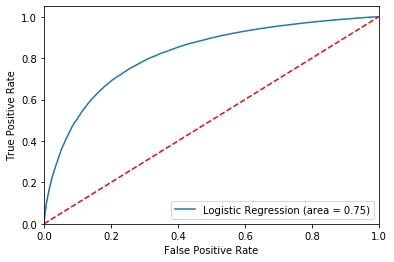

In [0]:
draw_roc_auc(y_test, X_test, logreg)

### 2. Decision Tree

In [0]:
tree = DecisionTreeClassifier()
parameters = {'max_depth': [70, 80, 90],
              'max_features': [100,125,150]}
clf = GridSearchCV(tree, parameters, cv = 3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [70, 80, 90],
                         '

In [0]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=70, max_features=125, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=90, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
tree.fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(tree.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.65


In [0]:
y_pred = tree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[9073 4883]
 [4936 8817]]


In [0]:
tn, fp, fn, tp = confusion_matrix.ravel()
print(f'Precision: {np.round(tp/(tp+fp),2)}')
print(f'recall: {np.round(tp/(tp+fn),2)}')

Precision: 0.64
recall: 0.64


In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

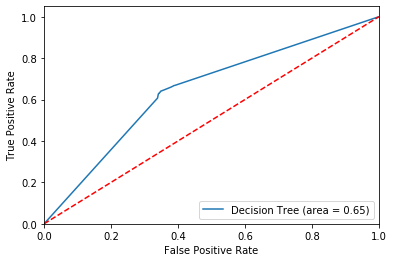

In [0]:
draw_roc_auc(y_test, X_test, tree)

### 3. Random Forest

In [0]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [1000, 1500, 2000]}
clf = GridSearchCV(rf, parameters)
clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [0]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(X_train_res, y_train_res)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.73


In [0]:
y_pred = rf.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[20473  6295]
 [31113 80661]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.76      0.52     26768
           1       0.93      0.72      0.81    111774

    accuracy                           0.73    138542
   macro avg       0.66      0.74      0.67    138542
weighted avg       0.83      0.73      0.76    138542



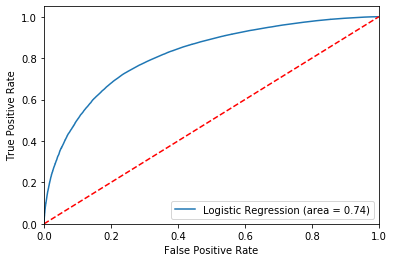

In [0]:
draw_roc_auc(y_test, X_test, rf)

# N-Grams

In [0]:
def get_lemmatized_text(corpus):
    '''
    lemmatization
    '''
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

In [0]:
review_copy['reviewText'] = get_lemmatized_text(review_copy['reviewText'])

In [0]:
review_copy['reviewText'][0]

'everyon differ great razor blade tri seeral includ astra wilkinson sword feather sever other seem give best cleanest shave blade seem last 3 shave averag buy 100ct pack last year'

top 500 bigrams (can be removed)

In [0]:
# create bi-grams
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2), stop_words = 'english')
reviews_vec = vectorizer.fit_transform(review_copy['reviewText'])

In [0]:
def topnbigrams(reviews_vec, n):
    
    # calculate the frequencies of each bi-gram
    freq = reviews_vec.sum(axis=0)
    
    # create a dictionary with big-grams and their corresponding frequencies
    vocab_list = vectorizer.get_feature_names()
    freq = np.array(freq).reshape(-1)
    freq_dict = {vocab_list[i]:freq[i] for i in range(len(freq))}
    
    top500bgfreq = Counter(freq_dict).most_common(n)
    
    top500bg = list()
    for i in range(n):
        top500bg.append(top500bgfreq[i][0])
    return top500bg

In [0]:
top500bigrams = topnbigrams(reviews_vec, 500)
top500bigrams

['use product',
 'fish oil',
 'work great',
 'highli recommend',
 'feel like',
 'long time',
 'everi day',
 'weight loss',
 'work better',
 'product work',
 'easi use',
 'great product',
 'realli like',
 'make sure',
 'year ago',
 'blood pressur',
 'look like',
 'smell like',
 'tast like',
 'time use',
 'gel cap',
 'good product',
 'work fine',
 'year old',
 'product use',
 'decid tri',
 'shave cream',
 'close shave',
 'lose weight',
 'recommend product',
 'read review',
 'littl bit',
 'wast money',
 'everi time',
 'pretti good',
 'sensit skin',
 'brush head',
 'save money',
 'paper towel',
 'continu use',
 'time day',
 'heart rate',
 'start use',
 'tri product',
 'good price',
 'feel better',
 'high qualiti',
 'realli work',
 'like product',
 'tast good',
 'use use',
 'great price',
 'realli help',
 'toilet paper',
 'use time',
 'notic differ',
 'good thing',
 'good job',
 'krill oil',
 'tri use',
 'sever time',
 'realli good',
 'protein powder',
 'product like',
 'electr razor',
 'wa

train/test split and oversampling

In [0]:
X = reviews_vec
y = review_copy['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [0]:
print("Counts of label '1': {}".format(sum(y_train == 1))) 
print("Counts of label '0': {}".format(sum(y_train == 0))) 

Counts of label '1': 20816
Counts of label '0': 20746


## Models

### 1. Logistic Regression

In [0]:
logreg = LogisticRegression()
parameters = {'C': [0.5, 1], 
              'solver': ('lbfgs', 'saga'),
              'max_iter': [100, 200]}

In [0]:
warnings.filterwarnings("ignore")
lr_cv = GridSearchCV(logreg, parameters)
lr_cv.fit(X_train, y_train)
lr_cv.best_params_

{'C': 0.5, 'max_iter': 100, 'solver': 'lbfgs'}

In [0]:
y_pred = lr_cv.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_cv.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [0]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[10573  3383]
 [ 3521 10232]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75     13956
           1       0.75      0.74      0.75     13753

    accuracy                           0.75     27709
   macro avg       0.75      0.75      0.75     27709
weighted avg       0.75      0.75      0.75     27709



In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

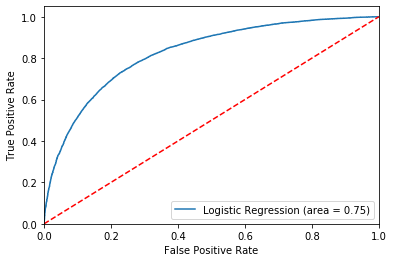

In [0]:
draw_roc_auc(y_test, X_test, lr_cv)

### 2. Decision Tree

In [0]:
tree = DecisionTreeClassifier()
parameters = {'max_depth': [1000, 2000],
              'max_features': ['sqrt', 'log2']}

In [0]:
tree_cv = GridSearchCV(tree, parameters)
tree_cv.fit(X_train, y_train)
warnings.filterwarnings("ignore")
tree_cv.best_params_

{'max_depth': 2000, 'max_features': 'sqrt'}

In [0]:
y_pred = tree_cv.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.64


In [0]:
confusion_matrix_tree = confusion_matrix(y_test, y_pred)
print(confusion_matrix_tree)

[[9932 4024]
 [6057 7696]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66     13956
           1       0.66      0.56      0.60     13753

    accuracy                           0.64     27709
   macro avg       0.64      0.64      0.63     27709
weighted avg       0.64      0.64      0.63     27709



In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

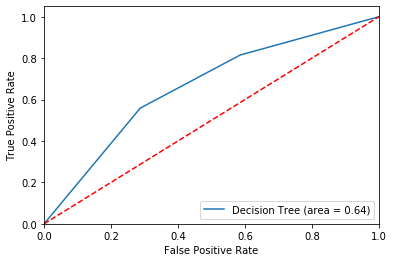

In [0]:
draw_roc_auc(y_test, X_test, tree_cv)

### 3. Random Forest

In [0]:
rf = RandomForestClassifier()

parameters = {'n_estimators': [50, 100], 
              'max_features': ['auto', 'log2']}

In [0]:
rf_cv = GridSearchCV(rf, parameters)
rf_cv.fit(X_train, y_train)
warnings.filterwarnings("ignore")
rf_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_cv = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_cv.fit(X_train, y_train)

y_pred = rf_cv.predict(X_test)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf_cv.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.72


In [0]:
confusion_matrix_rf = confusion_matrix(y_test, y_pred)
print(confusion_matrix_rf)

[[10566  3390]
 [ 4274  9479]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     13956
           1       0.74      0.69      0.71     13753

    accuracy                           0.72     27709
   macro avg       0.72      0.72      0.72     27709
weighted avg       0.72      0.72      0.72     27709



In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

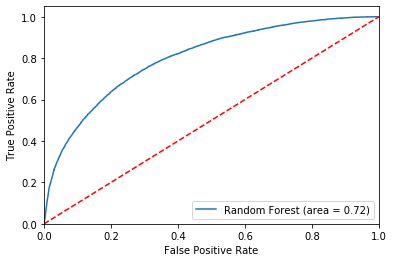

In [0]:
draw_roc_auc(y_test, X_test, rf_cv)

# TF-IDF

In [0]:
review_TF = review_bow.copy()
review_TF.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,binary
157458,AJP7IKVQXDJ7G,B0026MRA1W,Edward Grey,"[1, 1]",everyon differ great razor blade tri seeral in...,5,great blades.,1358985600,"01 24, 2013",1
188454,A1AO7ZWG22YOH6,B00347A4RU,Atey 771,"[1, 1]",good companion lone guy review right tuff stuf...,5,Limp Bisket meet my turkey,1399075200,"05 3, 2014",1
333781,A12B0LILOPQZYC,B00GK618LI,ivan tzonkov,"[0, 0]",taken glutamin power gym,5,Five Stars,1404432000,"07 4, 2014",1
112104,AFLE28KSLQKDQ,B0017K8VTE,Amazon Customer,"[15, 20]",import note enzymat therapi not_mak box kit an...,2,"hello bathroom and ""fat pants""!",1362268800,"03 3, 2013",0
234696,A299RHMH1M9PIW,B004QE83VE,Moderate Risk,"[0, 1]",gillett venu proskin moistur rich razor produc...,5,Shaves Past the Competition,1311206400,"07 21, 2011",1


In [0]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(review_TF["reviewText"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X = tfidf_vectorizer.transform(review_TF["reviewText"])
y = review_TF['binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Models

### 1. Logistic Regression

In [0]:
logreg = LogisticRegression()
parameters = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 
              'max_iter': [100, 150, 200]}
clf = GridSearchCV(logreg, parameters)
clf.fit(X_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2'], 'max_iter': [100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
clf.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
logreg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [0]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11288  2100]
 [ 3241 11080]]


In [0]:
tn, fp, fn, tp = confusion_matrix.ravel()
print(f'Precision: {np.round(tp/(tp+fp),3)}')
print(f'recall: {np.round(tp/(tp+fn),3)}')

Precision: 0.841
recall: 0.774


In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

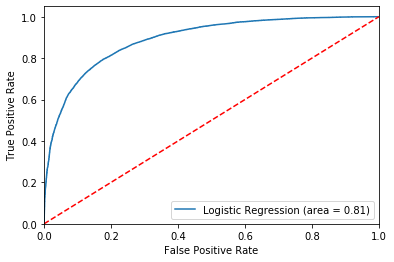

In [0]:
draw_roc_auc(y_test, X_test, logreg)

### 2. Decision Tree

In [0]:
tree = DecisionTreeClassifier()
parameters = {'max_depth': [70, 80, 90],
              'max_features': [100,125,150]}
clf = GridSearchCV(tree, parameters, cv = 3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [70, 80, 90],
                         '

In [0]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=90, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=90, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
tree.fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(tree.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.60


In [0]:
y_pred = tree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7170 6786]
 [4328 9425]]


In [0]:
tn, fp, fn, tp = confusion_matrix.ravel()
print(f'Precision: {np.round(tp/(tp+fp),2)}')
print(f'recall: {np.round(tp/(tp+fn),2)}')

Precision: 0.58
recall: 0.69


In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

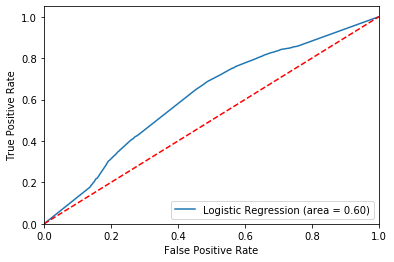

In [0]:
draw_roc_auc(y_test, X_test, tree)

### 3. Random Forest

In [0]:
rf = RandomForestClassifier(n_estimators=500)
parameters = {
    'max_depth': [70, 80, 90],
    'max_features': [100,125,150]}
clf = GridSearchCV(rf, parameters, cv = 3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [70, 80, 90], 'max_features': [100, 125, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=125, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
# Remember to update the parameters!
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=125, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train, y_train)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.79


In [0]:
y_pred = rf.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11178  2778]
 [ 3080 10673]]


In [0]:
tn, fp, fn, tp = confusion_matrix.ravel()
print(f'Precision: {np.round(tp/(tp+fp),2)}')
print(f'recall: {np.round(tp/(tp+fn),2)}')

Precision: 0.81
recall: 0.76


In [0]:
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

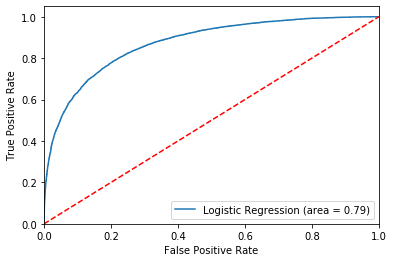

In [0]:
draw_roc_auc(y_test, X_test, rf)

### 4. SVM(Depreciated)

In [0]:
parameters = {'C': np.logspace(-3,3,7), 'gamma': np.logspace(-3,3,7),'kernel': ['rbf', 'sigmoid']}
svm = SVC(probability = True)
clf = GridSearchCV(svm, parameters, cv = 3)
clf.fit(X_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
clf.best_estimator_

In [0]:
svm = SVC(probability = True) 
svm.fit(X_train, y_train)
print("Accuracy of SVM classifier on test set: {:.2f}".format(svm.score(X_test, y_test)))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Performance Intepretation

### We applied three text representation techniques: Bag of Words, TF-IDF, n-Grams. For each technique, we used three predictive algorithms: logistic model, decison tree, and random forest. 

### Our best model is the logistic regression applied on TF-IDF data, with AUC = 0.81. The second best model is the random forest model applied on TF-IDF data with AUC =0.79. 

### When we set the thredshold as 0.5, logistic_TF-IDF model gives Precision = 0.841, and recall: 0.774. RF_TF-IDF model gives Precision = 0.81, and recall = 0.76. 

### High precision means that the model returned substantially more relevant results than irrelevant ones. In this case, precision measures how many cases are actually positive among all the cases that are predicted positive. While high recall means that an algorithm returned most of the relevant results. In this case, recall measures of how many truly positive results are predicted.

### Take precision score = 0.841 as an example. If the model predicts that 100 customers are satisfied, 84 of them actually give an overall score 4 or 5 to the item.

### AUC represents degree or measure of separability when the thredshold varies from 0-1. It tells how much model is capable of distinguishing between classes (in our case, have diabetes or not). AUC = 1 means the model is perfectly able to distinguish between positive class and negative class. AUC = 0.5 means the model is just randomly guessing. Therefore, both models have fairly good separability. 

# Aggregation on customer level

In [0]:
col = list(review_bow.columns[11:]) + ['reviewerID']
X = review_bow[col]

X_all = X[X.columns[:-1]]
y_pred = logreg.predict(X_all)

In [0]:
review_pred = X.copy()
review_pred['satisfactory'] = y_pred

In [0]:
reviewer_satisfactory = review_pred[['reviewerID', 'satisfactory']].groupby('reviewerID').mean()
reviewer_satisfactory[reviewer_satisfactory['satisfactory'] <= 0.3].head()

,satisfactory
reviewerID,
A1008DPSP6KC9J,0.250000
A105TOJ6LTVMBG,0.214286
A106JSOKVUJSH1,0.200000
A106JV1I3L7HAP,0.200000
A10ABG9NA9HYG7,0.000000


__WordCloud__

In [0]:
reviewer_list = reviewer_satisfactory[reviewer_satisfactory['satisfactory'] <= 0.5].index
selected_ID = review_bow[review_bow['reviewerID'].isin(reviewer_list)]

In [0]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in selected_ID.reviewText:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

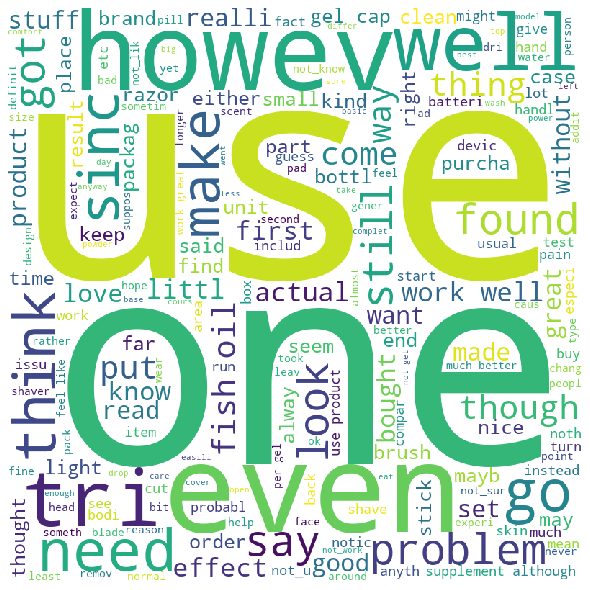

In [0]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [0]:
selected_product = review_bow[review_bow['overall'] <= 1]

In [0]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in selected_product.reviewText:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

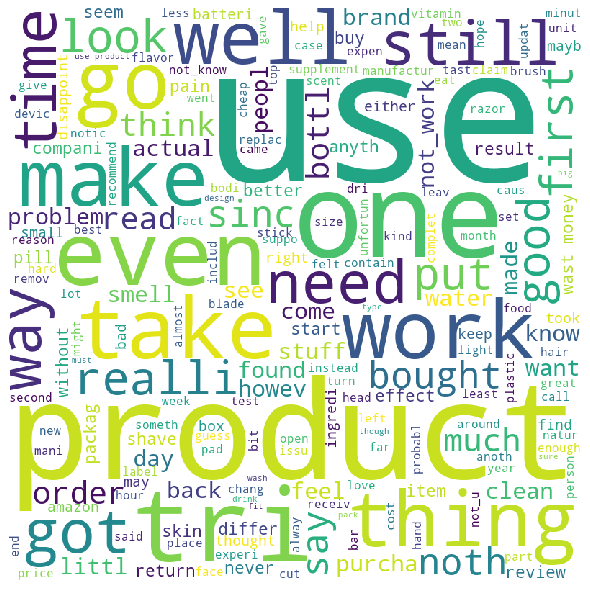

In [0]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()